<a href="https://colab.research.google.com/github/fereshteh-bahadory/Conditional-GAN/blob/main/conditionalgan_fashin_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN

Working with fashion_mnsit dataset from keras datadets. This dataset contains 28*28 images of 10 different categories.

## Importing libraries

In [1]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Input,Dense, Flatten, Reshape, Dropout, multiply, BatchNormalization, Conv2D, Conv2DTranspose
from keras.layers import Activation, Embedding, ZeroPadding2D, LeakyReLU
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

## Load dataset from keras

In [2]:
mnist_data=fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
(X_train,y_train),(X_test,y_test)=mnist_data

In [4]:
print("single image dim",X_train[0].shape)
print("dimension of train dataset",X_train.shape,y_train.shape)
print("dimension of test dataset",X_test.shape,y_test.shape)

single image dim (28, 28)
dimension of train dataset (60000, 28, 28) (60000,)
dimension of test dataset (10000, 28, 28) (10000,)


Different images and their classes. The numbers above the images shows the class.

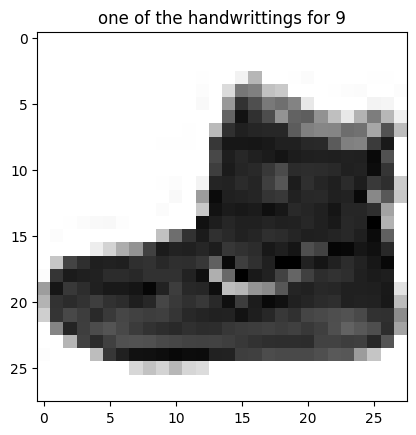

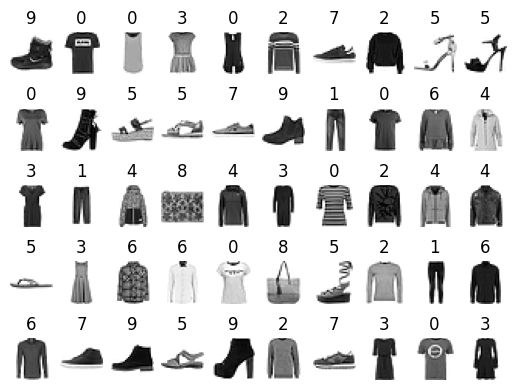

In [5]:
a=y_train[0]
plt.imshow(X_train[0],cmap='gray_r')
plt.title(f"one of the handwrittings for {a}")
plt.show()

for i in range(50):
    a=y_train[i]
    plt.subplot(5,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i],cmap='gray_r')
    plt.title(f"{a}")
plt.show()

## Generator model
GAN models contain generator and discriminator. We first define generator with LeakyReLU and tanh as activation functions.

In [6]:
#generator model function
def mnsit_cgan_generator(input_random_noise_shape, random_noise_vector_dim):
    mnsit_cgan_model = Sequential()
    mnsit_cgan_model.add(Dense(256,input_dim=random_noise_vector_dim))
    mnsit_cgan_model.add(LeakyReLU(alpha=0.2))
    mnsit_cgan_model.add(BatchNormalization(momentum=0.8))

    mnsit_cgan_model.add(Dense(512))
    mnsit_cgan_model.add(LeakyReLU(alpha=0.2))
    mnsit_cgan_model.add(BatchNormalization(momentum=0.8))

    mnsit_cgan_model.add(Dense(1024))
    mnsit_cgan_model.add(LeakyReLU(alpha=0.2))
    mnsit_cgan_model.add(BatchNormalization(momentum=0.8))

    mnsit_cgan_model.add(Dense(np.prod(input_random_noise_shape),activation='tanh'))

    mnsit_cgan_model.add(Reshape(input_random_noise_shape))
    return mnsit_cgan_model

In [7]:
#testing function and model
mnsit_cgan= mnsit_cgan_generator((28,28,1),100)
mnsit_cgan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

For conditional GAN, we should define and use labels for each category, so we can use them later to generate objects from each category.

In [8]:
#Generator labels,
#now we define condition labels
random_noise_vector=Input(shape=(100,))
conditioning_label=Input(shape=(1,),dtype='int32')

#keras embedding layer turns conditioning labels to a dense vestor of the latent dimension size
#number of classes=10 and latent dimension=100
#Flatten() converts 3D tensor into 2D tensor
conditioning_label_embedding=Flatten()(Embedding(10,100)(conditioning_label))

#combine the label embedding with the noise vector into a join representation by using  Multiply layer
#Multiply layer multiplies two vector of equal lenght and outputs a single vector which is
#the elementwise peoduct of the random_noise_vector and the label_embedding
joint_representation = multiply([random_noise_vector,conditioning_label_embedding])

#joined representation is used as an input of the Gan generator network
#which generates image for given label in joint representation
generated_image=mnsit_cgan(joint_representation)

#create new gan generator models with these parameters
mnsit_cgan=Model([random_noise_vector,conditioning_label],generated_image)

print(mnsit_cgan.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               1000      ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten (Flatten)           (None, 100)                  0         ['embedding[0][0]']           
                                                                                              

## Discriminator model

In [9]:
#discriminator model function
def mnsit_cgan_discriminator(input_img_shape):
    mnsit_cgan_discriminator_model = Sequential()

    mnsit_cgan_discriminator_model.add(Dense(512,input_dim=np.prod(input_img_shape)))
    mnsit_cgan_discriminator_model.add(LeakyReLU(alpha=0.2))
    mnsit_cgan_discriminator_model.add(Dropout(0.4))

    mnsit_cgan_discriminator_model.add(Dense(512))
    mnsit_cgan_discriminator_model.add(LeakyReLU(alpha=0.2))
    mnsit_cgan_discriminator_model.add(Dropout(0.4))

    mnsit_cgan_discriminator_model.add(Dense(512))
    mnsit_cgan_discriminator_model.add(LeakyReLU(alpha=0.2))
    mnsit_cgan_discriminator_model.add(Dropout(0.4))

    mnsit_cgan_discriminator_model.add(Dense(1,activation='sigmoid'))
    return mnsit_cgan_discriminator_model

In [10]:
#testing function and model
mnsit_cgan_disciminator= mnsit_cgan_discriminator((28,28,1))
mnsit_cgan_disciminator.summary()
#12928=128\times 100+ number of bias(128)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)              

Discriminator labels

In [11]:
#discriminator label

#create an input shape
input_image=Input(shape=(28,28,1)) #shape of our images
#conditioning label for input image (for this dataset an integer from 0 to 9)
conditioning_label=Input(shape=(1,),dtype='int32')

label_embedding=Flatten()(Embedding(10, np.prod((28,28,1)))(conditioning_label))

flat_nput_image=Flatten()(input_image)

joint_representation=multiply([flat_nput_image,label_embedding])

classification=mnsit_cgan_disciminator(joint_representation)

mnsit_cgan_disciminator=Model([input_image,conditioning_label],classification)
print(mnsit_cgan_disciminator.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 784)               7840      ['input_4[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 784)                  0         ['input_3[0][0]']             
                                                                                            

In [12]:
# compile GAN discriminator using binary classification and Adam optimizer
mnsit_cgan_disciminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002,0.5), metrics=['accuracy'])
#keep the discriminator non-trainable during training of the generator
mnsit_cgan_disciminator.trainable=False

random_noise_vector=Input(shape=(100,))
#conditioning label for input image (for this dataset an integer from 0 to 9)
conditioning_label=Input(shape=(1,))

input_image=Input(shape=(28,28,1)) #shape of our images
#conditioning label for input image (for this dataset an integer from 0 to 9)
conditioning_label=Input(shape=(1,))

generated_image=mnsit_cgan([random_noise_vector,conditioning_label])

classification=mnsit_cgan_disciminator([generated_image,conditioning_label])

mnsit_cgan_combined=Model([random_noise_vector,conditioning_label],classification)
mnsit_cgan_combined.compile(loss="binary_crossentropy", optimizer=Adam(0.0002,0.5))

print(mnsit_cgan_combined.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 model (Functional)          (None, 28, 28, 1)            1494520   ['input_5[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 1)                    935585    ['model[0][0]',         

In [13]:
# define global arrays for holding metices and iteration
loss_list=[]
accuracy_list=[]
iteration_list=[]
#define a function for training
def train():
    #define hyper parameters
    batch_size=128
    number_of_iteration=19000 #number of cycles for training
    sample_gap=50 #sample interval for printing the log

    mnist_data=fashion_mnist.load_data()
    (X_train,y_train),(X_test,y_test)=mnist_data

    #create a 3d numpy array, height width and number of images
    X_train = np.expand_dims(X_train, axis=3)

    # we have to convert the images from 0 to 255 into -1 to 1, because we want it to be fit with the outpot of the activation function, tanh
    X_train=X_train/127.5 -1

    #create a 3d numpy array, height width and number of images
    X_train = np.expand_dims(X_train, axis=3)

    #create labels for real and fake images
    real_image_label=np.ones((batch_size,1))
    fake_image_label=np.zeros((batch_size,1))

    #Define a for loop to run untill the iteration is defined
    for i in range(number_of_iteration):
        #get a batch of images based on b_size from the preprocessed dataset randomly
        random_ints=np.random.randint(0,X_train.shape[0],batch_size)
        real_imgs=X_train[random_ints]
        real_labels=y_train[random_ints]

        discriminator_real_accuracy=mnsit_cgan_disciminator.train_on_batch([real_imgs,real_labels],real_image_label)
        #random noise from normal distribution, we have 100 numbers with std=1 and mean=0
        random_noise_vector=np.random.normal(0,1,(batch_size,100))

        sample_labels=np.random.randint(0,10,batch_size).reshape(-1,1)

        fake_generated_imgs=mnsit_cgan.predict([random_noise_vector,real_labels])
        discriminator_fake_accuracy=mnsit_cgan_disciminator.train_on_batch([fake_generated_imgs,real_labels],fake_image_label)

        discriminator_loss, discriminator_accuracy=0.5*np.add(discriminator_real_accuracy,discriminator_fake_accuracy)
        #train combined gan with fake images and get loss with random niose and real labes
        random_noise_vector=np.random.normal(0,1,(batch_size,100))
        generator_loss = mnsit_cgan_combined.train_on_batch([random_noise_vector,sample_labels],real_image_label)
        print("Iteration: %d" %(i+1))

        # to save and plot the log
        if (i+1)%sample_gap==0:
            loss_list.append((discriminator_loss,generator_loss))
            accuracy_list.append(discriminator_accuracy*100)
            iteration_list.append(i+1)

            print("Iteration: %d, discriminator loss: %.2f, discriminitro accuracy: %.2f, generator loss: %.2f"
              %(i+1,discriminator_loss, discriminator_accuracy*100, generator_loss))
            plot_progress(accuracy_list,loss_list)
            #plot sample images
            plot_sample_generated(mnsit_cgan)
            #
            #
            #save the model
            model_json=mnsit_cgan.to_json()
            #save the model in 'saved models'
            with open("/content/Models/fashion_mnsit_cgan.json","w") as json_file:
                json_file.write(model_json)
            #save the weights
            mnsit_cgan.save_weights("/content/Models/fashion_mnsit_cgan_weights.h5")
            print("the model and weights are saved")

In [14]:
def plot_progress(accuracy_list,loss_list):
    plt.plot(accuracy_list)
    plt.plot(loss_list[0])
    plt.title("accuracy and loss vs number of iteration")
    plt.ylabel("accuracy and loss")
    plt.xlabel("number of epochs")
    plt.legend(['accuracy','loss'],loc="upper left")
    plt.show()

In [15]:
def plot_sample_generated(mnsit_cgan):
    random_noise_vector=np.random.normal(0,1,(2*5,100))
    #create sample labels
    sample_labels=np.arange(0,10).reshape(-1,1)
    #pass random noise to the model for prediction
    base_generated_imgs=mnsit_cgan.predict([random_noise_vector,sample_labels])
    #rescale the imgs for plotting
    generated_imgs=0.5*base_generated_imgs+0.5
    #preparing subplot
    fig, ax=plt.subplots(2,5)
    #plt.figure(figsize=(4, 4))  # Set the figure size
    #plt.subplots_adjust(sharey=True, sharex=True)  # Share axes
    counter=0
    for i in range(2):
        for j in range(5):
            ax[i,j].imshow(generated_imgs[counter,:,:],cmap='gray')
            ax[i,j].set_title("label is %d"%sample_labels[counter])
            ax[i,j].axis('off')
            counter += 1
    plt.show()

In [ ]:
train()